In [1]:
place = 'Pittsburgh, Pennsylvania, USA'

In [2]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import copy
%matplotlib inline

ox.config(data_folder="temp",log_file=False, log_console=True, use_cache=True)

In [3]:
# get a graph for whole city with additional buffer
pgh_full = ox.graph_from_place(place,
                          network_type="drive_service",
                          retain_all=True, simplify=True, truncate_by_edge=False, clean_periphery=True,
                          buffer_dist=900, name="PGH Full drive")
# Reproject for faster processing
pgh_full_prj = ox.project_graph(pgh_full)
pgh_full_prj_bak = copy.deepcopy(pgh_full_prj)

In [4]:
ox.save_graph_shapefile(pgh_full_prj, filename="full_20180709_shp")
ox.save_graphml(pgh_full_prj, filename="full_20180709_gml")

In [5]:
print("Node number: %d" % pgh_full_prj.number_of_nodes())
print("Edge number: %d" % pgh_full_prj.number_of_edges())

Node number: 20930
Edge number: 56341


In [6]:
import csv
with open('edges.csv','r') as lineData:
    lineData = csv.reader(lineData)
    edge_header = next(lineData)
    edges = [row for row in lineData]
with open('nodes.csv','r') as lineData:
    lineData = csv.reader(lineData)
    node_header = next(lineData)
    nodes = [row for row in lineData]

In [7]:
def idData(i):
    return edge_header.index(i)
def nodeData(i):
    return node_header.index(i)

In [8]:
for n in nodes:
    # Make sure every id in nodes' list are numeric val
    a = nodeData("osmid")
    assert n[a] == str(int(n[a]))

In [9]:
for e in edges:
    # Make sure every id in edges' list are numeric val
    a = idData("from_")
    b = idData("to")
    assert e[a] == str(int(e[a]))
    assert e[b] == str(int(e[b]))

In [10]:
def addAttrEdge(k,f,t,r,o,s):
    if(s=='False'):
        pgh_full_prj.add_edge(f, t, key=k, river_bridge=r, out_boundary=o)
        pgh_full_prj.add_edge(t, f, key=k, river_bridge=r, out_boundary=o)
    else:
        pgh_full_prj.add_edge(f, t, key=k, river_bridge=r, out_boundary=o)

def addAttrNode(i,r,o):
    pgh_full_prj.add_node(int(i), river_bridge=r, out_boundary=o)

> First add attributes for nodes

In [11]:
pgh_full_prj.node[104185739]

{'highway': nan,
 'osmid': '104185739',
 'ref': nan,
 'x': 581420.2912886604,
 'y': 4477532.508123032,
 'lon': -80.0399041,
 'lat': 40.4444611}

In [12]:
for node in nodes:
    oid = node[nodeData("osmid")]
    o = node[nodeData("out_pgh")]
    r = node[nodeData("river_bge")]
    addAttrNode(oid,r,o)

In [13]:
pgh_full_prj.node[104185739]

{'highway': nan,
 'osmid': '104185739',
 'ref': nan,
 'x': 581420.2912886604,
 'y': 4477532.508123032,
 'lon': -80.0399041,
 'lat': 40.4444611,
 'river_bridge': '0',
 'out_boundary': '0'}

In [14]:
print("Node number: %d" % pgh_full_prj.number_of_nodes())
print("Edge number: %d" % pgh_full_prj.number_of_edges())

Node number: 20930
Edge number: 56341


In [15]:
for n in pgh_full_prj.nodes(data=True):
    assert n[1]['river_bridge'] is not None
    assert n[1]['out_boundary'] is not None

> Then add attributes for edges

In [16]:
for edge in edges:
    assert pgh_full_prj.has_edge(int(edge[idData("from_")]),int(edge[idData("to")]))

In [17]:
pgh_full_prj[104185746][104185739]

AtlasView({0: {'osmid': 11651757, 'lanes': '2', 'name': 'Ainsworth Street', 'highway': 'residential', 'oneway': False, 'length': 38.786}})

In [18]:
for a in range(len(pgh_full_prj[3836716075][3836714446])):
    print(pgh_full_prj[3836716075][3836714446][a])

{'osmid': 380333321, 'highway': 'service', 'oneway': False, 'length': 79.494, 'geometry': <shapely.geometry.linestring.LineString object at 0xa196f1358>}
{'osmid': 380333333, 'highway': 'service', 'oneway': False, 'length': 67.964, 'geometry': <shapely.geometry.linestring.LineString object at 0xa196f1320>}


In [19]:
for a in range(len(pgh_full_prj[3836714446][3836716075])):
    print(pgh_full_prj[3836714446][3836716075][a])

{'osmid': 380333321, 'highway': 'service', 'oneway': False, 'length': 79.494, 'geometry': <shapely.geometry.linestring.LineString object at 0xa196f1160>}
{'osmid': 380333333, 'highway': 'service', 'oneway': False, 'length': 67.964, 'geometry': <shapely.geometry.linestring.LineString object at 0xa196f1128>}


In [20]:
count_multi = 0
count_mod = 0
for edge in edges:
    f = int(edge[idData("from_")])
    t = int(edge[idData("to")])
    o = edge[idData("out_pgh")]
    r = edge[idData("river_bge")]
    s = edge[idData("oneway")]
    oid = edge[idData("osmid")]
    eoi = pgh_full_prj[f][t]
    num_edge = len(eoi)
    if(num_edge == 1): # Only ONE connection
        addAttrEdge(0,f,t,r,o,s)
    else:
        count_multi += 1
        for i in range(num_edge):
            if(str(eoi[i]['osmid']) == str(oid)):
                print("Multi-match log: %d,%d,%d" % (f,t,i))
                count_mod += 1
                addAttrEdge(i,f,t,r,o,s)
    # No new edges should be added!
    assert len(pgh_full_prj[f][t]) == num_edge

print("Multi-node count: %d" % count_multi)
print("Multi-node modified count: %d" % count_mod)

Multi-match log: 104193301,1808817218,1
Multi-match log: 104202218,104202218,0
Multi-match log: 104202218,104202218,1
Multi-match log: 104248713,104363319,1
Multi-match log: 104363319,104248713,1
Multi-match log: 104356736,104356736,0
Multi-match log: 104356736,104356736,1
Multi-match log: 1849109847,104362177,0
Multi-match log: 1849109847,104362177,1
Multi-match log: 1384159282,104362823,0
Multi-match log: 1384159282,104362823,1
Multi-match log: 104368197,104368181,0
Multi-match log: 104368197,104368181,1
Multi-match log: 104373105,1640748487,0
Multi-match log: 104373105,1640748487,1
Multi-match log: 1640748487,104373105,0
Multi-match log: 1640748487,104373105,1
Multi-match log: 104384856,104483852,0
Multi-match log: 104384856,104483852,1
Multi-match log: 104483852,104384856,0
Multi-match log: 104483852,104384856,1
Multi-match log: 104402366,104402366,0
Multi-match log: 104402366,104402366,1
Multi-match log: 107560551,104441633,0
Multi-match log: 107560551,104441633,1
Multi-match log:

In [21]:
for e in pgh_full_prj.edges(data=True, keys=True):
    if 'river_bridge' not in e[3] or 'out_boundary' not in e[3]:
        print(e)

(104248713, 104363319, 0, {'osmid': 11824006, 'name': 'Redwood Street', 'highway': 'residential', 'oneway': False, 'length': 91.15, 'geometry': <shapely.geometry.linestring.LineString object at 0xa191e58d0>})
(104363319, 104248713, 0, {'osmid': [11697576, 11965426], 'name': ['Lybrig Way', 'Park Boulevard'], 'highway': ['residential', 'service'], 'oneway': False, 'length': 241.512, 'geometry': <shapely.geometry.linestring.LineString object at 0xa191ef7f0>})
(104480581, 104995016, 1, {'osmid': 11747731, 'name': 'Johnston Avenue', 'highway': 'tertiary', 'oneway': False, 'length': 105.608, 'geometry': <shapely.geometry.linestring.LineString object at 0xa19206860>})
(104609243, 104762614, 0, {'osmid': [11692329, 11825935], 'name': ['Lohrman Way', 'Hethlon Street'], 'highway': ['residential', 'service'], 'service': 'alley', 'oneway': False, 'length': 181.91899999999998, 'geometry': <shapely.geometry.linestring.LineString object at 0xa19261eb8>})
(104611696, 104994499, 1, {'osmid': 11732281, 

In [22]:
print("Node number: %d" % pgh_full_prj.number_of_nodes())
print("Edge number: %d" % pgh_full_prj.number_of_edges())

Node number: 20930
Edge number: 56346


In [23]:
pgh_full_prj[104185746][104185739]

AtlasView({0: {'osmid': 11651757, 'lanes': '2', 'name': 'Ainsworth Street', 'highway': 'residential', 'oneway': False, 'length': 38.786, 'river_bridge': '0', 'out_boundary': '0'}})

In [24]:
pgh_full_prj[3765460187][104547825]

AtlasView({0: {'osmid': 24867593, 'name': 'South Aiken Avenue', 'highway': 'secondary', 'maxspeed': '25 mph', 'oneway': False, 'length': 30.656, 'river_bridge': '0', 'out_boundary': '0'}, 1: {'osmid': 373007121, 'highway': 'unclassified', 'oneway': False, 'length': 81.131, 'geometry': <shapely.geometry.linestring.LineString object at 0xa196dbdd8>, 'river_bridge': '0', 'out_boundary': '0'}})

In [25]:
pgh_full_prj[3836716075][3836714446]

AtlasView({0: {'osmid': 380333321, 'highway': 'service', 'oneway': False, 'length': 79.494, 'geometry': <shapely.geometry.linestring.LineString object at 0xa196f1358>, 'river_bridge': '0', 'out_boundary': '0'}, 1: {'osmid': 380333333, 'highway': 'service', 'oneway': False, 'length': 67.964, 'geometry': <shapely.geometry.linestring.LineString object at 0xa196f1320>, 'river_bridge': '0', 'out_boundary': '0'}})

> Finally plot and save out

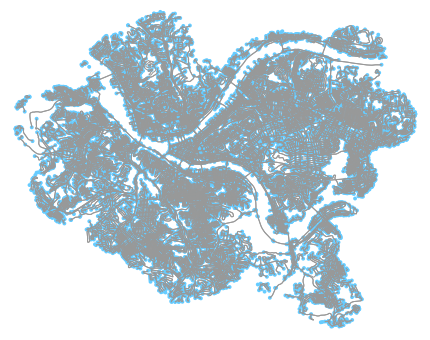

In [26]:
fig, ax = ox.plot_graph(pgh_full_prj)

In [27]:
ox.save_graphml(pgh_full_prj, filename='pgh_road_marked.graphml',gephi=True)